In [1]:
import pandas as pd

In [2]:
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

In [3]:
combined = pd.read_csv("output/5_combined.csv").set_index(["City","report_year"])
len(combined)

2705

In [4]:
len(combined[combined["has_nulls"] == True])

456

In [5]:
combined = combined[combined["has_nulls"] != True]
len(combined)

2249

In [6]:
combined = combined[combined["Grant Payments"].notnull()]
len(combined)

1669

In [7]:
!mkdir -p figures/for-viz/

In [8]:
cities = combined.index.map(lambda x: x[0]).unique()

# Adjust columns

In [9]:
# Grants per student
combined["grants_per_student"] = combined["Grant Payments"] / combined["EDSIGHT_ENROLLMENT"]

In [10]:
# Staffing per student
combined["fte_per_student"] = combined["FTE Count"] * 100 / combined["EDSIGHT_ENROLLMENT"]

In [11]:
# Teachers per student
combined["teacher_fte_per_student"] = combined["Teacher FTE Count"] * 100 / combined["EDSIGHT_ENROLLMENT"]

# Enrollment

Unadjusted:
    1. Grant payments
    2. Staffing
    3. Teachers
    
Adjusted
    1. Grant payments per student
    2. Staffing per student
    3. Teacher staffing per student
    
Enrollment

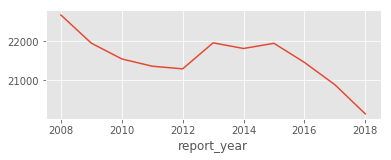

In [12]:
import humanize
def town_chart(city, col="EDSIGHT_ENROLLMENT"):
    ret = city.upper().strip()
    
    ret = combined.loc[ret]
    
    ax = ret[col].plot(figsize=(6,2))
    
    return ax

enrollment_chart = lambda x: town_chart(x, col="EDSIGHT_ENROLLMENT")
enrollment_chart("Hartford")

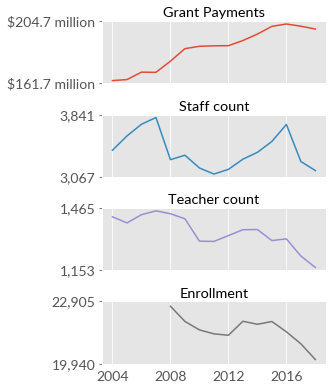

In [25]:
import matplotlib.ticker as mtick
from matplotlib import rcParams


def make_stack(city, charts, adjusted=False,xticks=[2004,2008,2012,2016]):
    plt.close()
    rcParams['font.family'] = 'sans-serif'
    rcParams['font.sans-serif'] = ['Lato']
    rcParams['axes.titlepad'] = 4
    matplotlib.rc('xtick', labelsize=14) 
    matplotlib.rc('ytick', labelsize=14) 

    tmpdf = combined[[x["column"] for x in charts]]
    titles = [x["title"] for x in charts]
    
    axs = tmpdf.loc[city].plot(
        subplots=True,
        legend=False,
        sharex=True,
        figsize=(4,7),
        xticks=xticks
    )
    
    
    
    i = 0 
    for cell in axs:
        cell.set_title(titles[i])
        #cell.xaxis.set_ticks_position('none') 
        #cell.xaxis.set_tick_params(rotation=90, ha="center")
        cell.set_xticklabels(xticks, rotation=0, ha="center")
        if "yfmt" in charts[i]:
            yfmt = charts[i]["yfmt"]
            ytick = mtick.FuncFormatter(yfmt)
            cell.yaxis.set_major_formatter(ytick)
        ln = cell.get_lines()
        min_max = [int(ln[0].get_data()[1].min() * 0.99),
                   int(ln[0].get_data()[1].max() * 1.01)]
        cell.set_yticks(min_max)
        cell.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            #labelbottom=False
        ) # labels along the bottom edge are off
        cell.xaxis.label.set_visible(False)

        i += 1
    
    plt.subplots_adjust(
        wspace=0.5, 
        hspace=0.5
    )

    #plt.suptitle(city, fontsize=20)

    return 
    
make_unadjusted_stack = lambda x: make_stack(x,[
        {
            "column":"Grant Payments",
            "title":"Grant Payments",
            "yfmt": lambda x, _: "$%s" % humanize.intword(x)
        },
        {
            "column":"FTE Count",
            "title":"Staff count",
            "yfmt": lambda x, _: "%s" % humanize.intcomma(x)
        },
        {
            "column":"Teacher FTE Count",
            "title":"Teacher count",
            "yfmt": lambda x, _: "%s" % humanize.intcomma(x)
        },
        {
            "column":"EDSIGHT_ENROLLMENT",
            "title":"Enrollment",
            "yfmt": lambda x, _: "%s" % humanize.intcomma(x)

        }

    ]
)

make_unadjusted_stack("HARTFORD")

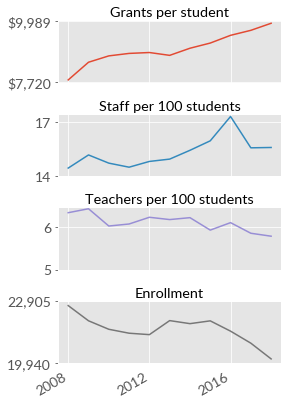

In [17]:
make_adjusted_stack = lambda x: make_stack(
    x,
    [
        {
            "column":"grants_per_student",
            "title":"Grants per student",
            "yfmt": lambda x, _: "$%s" % humanize.intcomma(x)
        },
        {
            "column":"fte_per_student",
            "title":"Staff per 100 students",
            "yfmt": lambda x, _: "%s" % humanize.intcomma(x)
        },
        {
            "column":"teacher_fte_per_student",
            "title":"Teachers per 100 students",
            "yfmt": lambda x, _: "%s" % humanize.intcomma(x)
        },
        {
            "column":"EDSIGHT_ENROLLMENT",
            "title":"Enrollment",
            "yfmt": lambda x, _: "%s" % humanize.intcomma(x)
        }

    ],
    xticks=[2008,2012,2016]
                                           
)

make_adjusted_stack("HARTFORD")

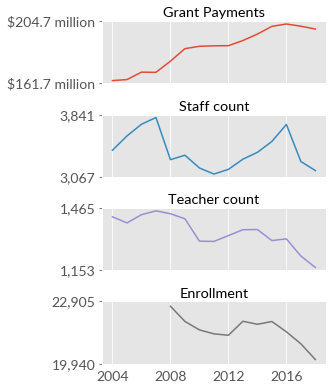

In [26]:
make_unadjusted_stack("HARTFORD")

In [ ]:
def save_adjusted_stack(c):
    make_adjusted_stack(c)
    plt.tight_layout()
    plt.gcf().savefig("figures/for-viz/%s-adjusted.png" % c.replace(" ","-"),bbox_inches='tight')
    plt.close()

def save_unadjusted_stack(c):
    make_unadjusted_stack(c)
    plt.tight_layout()
    plt.gcf().savefig("figures/for-viz/%s-unadjusted.png" % c.replace(" ","-"),bbox_inches='tight')
    plt.close()

from IPython.display import clear_output

print ("Starting...")
for c in cities:
    clear_output()
    print "%d of %d: %s" % (list(cities).index(c), len(cities), c)
    try:
        save_unadjusted_stack(c)
        save_adjusted_stack(c)
    except Exception as e:
        print ("ERROR %s: %s" % (c, e))